In [1]:
%load_ext autoreload
%autoreload 2
import warnings
import numpy as np
import torch
import random
import sys
sys.path.append("..")

warnings.filterwarnings('ignore') # ignore warnings
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


# Set seeds for reproducibility
seed = 82718
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)


# Uncertainty quantification in CausalPFN 

In the following, we run CausalPFN (with default parameters) on 25 synthetic Polynomial datasets with degrees within {2, 3, 4} to assess its uncertainty quantification and see how well-calibrated the model is. We will then run CausalPFN with `calibrate=True`. We show the calibration curve along with the integrated coverage error (ICE).

In [2]:
# Load datasets and required functions
%autoreload 2
from benchmarks import PolynomialDataset
from causalpfn import CATEEstimator
from benchmarks.base import CATE_Dataset
from causalpfn.evaluation import calculate_calibration_curve_scores
from tqdm import tqdm

# get 25 realizations of the synthetic polynomial datasets
datasets = PolynomialDataset(n_tables=25)

# Choose the number of bins for calibration curves
n_bins = 10

# Iterate through datasets and realizations
pbar = tqdm(total=len(datasets), desc="Processing datasets")

calibration_curves = []
ices = []

calibration_curves_with_calibrate = []
ices_with_calibrate = []


for k, dataset in enumerate(datasets):
    cate_dataset: CATE_Dataset = dataset[0]

    # Before calibration
    causalpfn_cate = CATEEstimator(
        device=device,
    )
    causalpfn_cate.fit(
        X=cate_dataset.X_train,
        t=cate_dataset.t_train,
        y=cate_dataset.y_train,
    )
    curve, ice = calculate_calibration_curve_scores(
        fitted_estimator=causalpfn_cate,
        X_test=cate_dataset.X_test,
        true_cate=cate_dataset.true_cate,
        n_bins=n_bins,
    )
    calibration_curves.append(curve)
    ices.append(ice)

    # After calibration
    causalpfn_cate = CATEEstimator(
        device=device,
        calibrate=True,  # Enable calibration
    )
    causalpfn_cate.fit(
        X=cate_dataset.X_train,
        t=cate_dataset.t_train,
        y=cate_dataset.y_train,
    )
    curve, ice = calculate_calibration_curve_scores(
        fitted_estimator=causalpfn_cate,
        X_test=cate_dataset.X_test,
        true_cate=cate_dataset.true_cate,
        n_bins=n_bins,
    )
    calibration_curves_with_calibrate.append(curve)
    ices_with_calibrate.append(ice)

    pbar.update(1)

pbar.close()

Processing datasets: 100%|██████████| 25/25 [06:57<00:00, 16.68s/it]


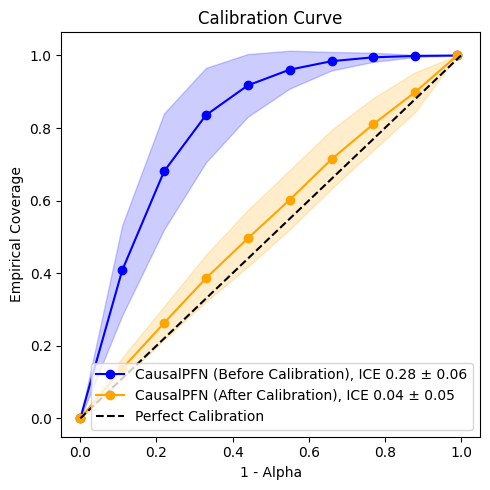

In [4]:
# Plot the calibration curve
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 1, figsize=(5, 5))
alpha_values = np.linspace(0.01, 1.0, n_bins)

curve_mean = np.mean(calibration_curves, axis=0)
curve_std = np.std(calibration_curves, axis=0)

curve_mean_with_calibrate = np.mean(calibration_curves_with_calibrate, axis=0)
curve_std_with_calibrate = np.std(calibration_curves_with_calibrate, axis=0)

axs.plot(
    1 - alpha_values,
    curve_mean,
    label=f"CausalPFN (Before Calibration), ICE {np.mean(ices):.2f} ± {np.std(ices):.2f}",
    color="blue",
    marker="o",
)

axs.fill_between(
    1 - alpha_values,
    curve_mean - curve_std,
    curve_mean + curve_std,
    color="blue",
    alpha=0.2,
)

axs.plot(
    1 - alpha_values,
    curve_mean_with_calibrate,
    label=f"CausalPFN (After Calibration), ICE {np.mean(ices_with_calibrate):.2f} ± {np.std(ices_with_calibrate):.2f}",
    color="orange",
    marker="o",
)

axs.fill_between(
    1 - alpha_values,
    curve_mean_with_calibrate - curve_std_with_calibrate,
    curve_mean_with_calibrate + curve_std_with_calibrate,
    color="orange",
    alpha=0.2,
)

axs.plot(
    [0, 1],
    [0, 1],
    linestyle="--",
    color="black",
    label="Perfect Calibration",
)
axs.set_xlabel("1 - Alpha")
axs.set_ylabel("Empirical Coverage")
axs.set_title("Calibration Curve")
axs.legend()
plt.tight_layout()
plt.show()